In [1]:
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import requests
import json
from scipy.stats import linregress
from config import weather_api_key

In [2]:
# Import the clean ufo data

ufo_df = pd.read_csv("Resources/usa_sights.csv")

# Keep only the columns needed for this analysis
ufo_df = ufo_df[["city", "year", "sightings", "date_time"]]

# Convert year column to string for concatenation
ufo_df["year"] = ufo_df["year"].astype(str)

# Empty list to store date
ymd = []
time = []

for index, row in ufo_df.iterrows():
    # Drop rows with other info in city column facilitiate API calls
    test = row["city"].split(" ")
    if len(test)>2:
        ufo_df = ufo_df.drop(index=index)
        
    else:
        # Get date in proper format to call API
        day = row["date_time"].split(" ")
        ymd.append(row["year"]+"-"+day[0])

        # Get time in proper format for API
        hours = day[1].split(":")
        time.append(hours[0])

ufo_df["date"] = ymd
ufo_df["time"] = time

# Convert time column to int to index API response
ufo_df["time"] = ufo_df["time"].astype(int)

ufo_df["city"] = ufo_df["city"].str.title()

# Only look at dates from 1970 and later (the API dates back to 2008)
ufo_df = ufo_df.loc[ufo_df["year"]>="2008"]

ufo_df

,city,year,sightings,date_time,date,time
146,North Branch,2008,1,10-10 02:00:00,2008-10-10,2
147,Slingerlands,2008,1,10-10 02:00:00,2008-10-10,2
148,Carlin,2008,1,10-10 04:00:00,2008-10-10,4
149,Evansville,2008,1,10-10 04:50:00,2008-10-10,4
150,Albany,2008,1,10-10 06:00:00,2008-10-10,6
...,...,...,...,...,...,...
63548,Nashville,2013,1,09-09 21:15:00,2013-09-09,21
63549,Boise,2013,1,09-09 22:00:00,2013-09-09,22
63550,Napa,2013,1,09-09 22:00:00,2013-09-09,22
63551,Vienna,2013,1,09-09 22:20:00,2013-09-09,22


In [3]:
# Get a population sample
ufo_sample = ufo_df.sample(n=500)
ufo_sample

,city,year,sightings,date_time,date,time
27520,Charlottesville,2013,1,03-30 20:20:00,2013-03-30,20
23379,Reading,2012,1,02-28 23:57:00,2012-02-28,23
33411,Huntsville,2014,1,05-01 20:30:00,2014-05-01,20
33528,Amherst,2010,1,05-12 23:30:00,2010-05-12,23
5380,Phoenix,2008,1,10-05 10:20:00,2008-10-05,10
...,...,...,...,...,...,...
39901,Hendersonville,2012,1,06-19 00:00:00,2012-06-19,0
63149,Heber City,2011,1,09-07 00:22:00,2011-09-07,0
35479,Mason City,2012,1,05-26 00:00:00,2012-05-26,0
54147,Abilene,2009,1,08-21 03:23:00,2009-08-21,3


In [4]:
# Create variables for storing weather information
temp = []
humidity = []
cloudcover = []
visibility = []
heatindex = []
moon_illumination = []

# Search parameters
params = {
    "access_key": weather_api_key,
    "query": "",
    "historical_date": "",
    "hourly": "1",
    "interval": "1",
    "units": "f"
}
baseUrl = "https://api.weatherstack.com/historical"

# Track the number of iterations
count = 0

# Interate through all ufo sightings and get weather information
for index, row in ufo_sample.iterrows():
    count += 1
    # Try to call API for given city and time
    try:
        params["query"] = row["city"] #change to row in loop
        params["historical_date"] = row["date"] #change to row in loop
        response = requests.get(baseUrl, params).json()
        # Store necessary information
        temp.append(response["historical"][params["historical_date"]]["hourly"][row["time"]]["temperature"])
        humidity.append(response["historical"][params["historical_date"]]["hourly"][row["time"]]["humidity"])
        cloudcover.append(response["historical"][params["historical_date"]]["hourly"][row["time"]]["cloudcover"])
        visibility.append(response["historical"][params["historical_date"]]["hourly"][row["time"]]["visibility"])
        heatindex.append(response["historical"][params["historical_date"]]["hourly"][row["time"]]["heatindex"])
        moon_illumination.append(response["historical"][params["historical_date"]]["astro"]["moon_illumination"])
        print(count, "getting data for", row["city"])
    # If not able to call, store NaN to later drop that row
    except:
        temp.append("NaN")
        humidity.append("NaN")
        cloudcover.append("NaN")
        visibility.append("NaN")
        heatindex.append("NaN")
        moon_illumination.append("NaN")
        print(count, "no info for", row["city"])

1 getting data for Charlottesville
2 getting data for Reading
3 getting data for Huntsville
4 getting data for Amherst
5 getting data for Phoenix
6 getting data for Orlando
7 getting data for San Francisco
8 getting data for Detroit
9 getting data for Walled Lake
10 getting data for Woodland
11 getting data for Brevard
12 getting data for Grand Bay
13 getting data for Morrison
14 getting data for Anaheim
15 getting data for Portland
16 getting data for Moreno Valley
17 getting data for Hemet
18 getting data for Topeka
19 no info for Brandon
20 getting data for Springdale
21 getting data for Punta Gorda
22 getting data for Rochester
23 getting data for Newark
24 getting data for Fort Collins
25 getting data for Wichita
26 getting data for La Crosse
27 getting data for Shelton
28 getting data for Moneta
29 getting data for Pukalani
30 getting data for Snoqualmie
31 getting data for Yakima
32 getting data for Federal Way
33 getting data for North Kingstown
34 getting data for Melbourne
35

273 no info for Cottage Grove
274 getting data for Hermann
275 getting data for Commerce
276 getting data for Cathedral City
277 getting data for Boston
278 getting data for New Bern
279 getting data for Coldwater
280 getting data for Cedar Falls
281 getting data for Fall River
282 getting data for Wilmington
283 getting data for Santa Rosa
284 getting data for Grayslake
285 getting data for Antioch
286 getting data for Monterey
287 getting data for Inman
288 getting data for Oak Lawn
289 getting data for Knoxville
290 getting data for Tomball
291 no info for Sharon
292 getting data for Council Bluffs
293 getting data for Fontana
294 getting data for Edna
295 getting data for Torrance
296 getting data for L&#39Anse
297 getting data for Warren
298 getting data for Sweetwater
299 getting data for Holts Summit
300 getting data for Commerce
301 getting data for Signal Mountain
302 getting data for Fenton
303 getting data for Menomonie
304 getting data for Oakville
305 getting data for Jeff

In [12]:
# Update ufo data frame to include weather infomation
ufo_sample["temp"] = temp
ufo_sample["humidity"] = humidity
ufo_sample["cloudcover"] = cloudcover
ufo_sample["visibility"] = visibility
ufo_sample["heatindex"] = heatindex
ufo_sample["moon_illumination"] = moon_illumination

# Drop NaN vaules if any
ufo_sample = ufo_sample.loc[ufo_sample["temp"]!="NaN"]

ufo_sample

,city,year,sightings,date_time,date,time,temp,humidity,cloudcover,visibility,heatindex,moon_illumination
27520,Charlottesville,2013,1,03-30 20:20:00,2013-03-30,20,41,72,26,6,41,72
23379,Reading,2012,1,02-28 23:57:00,2012-02-28,23,46,96,56,3,46,42
33411,Huntsville,2014,1,05-01 20:30:00,2014-05-01,20,52,76,10,6,52,9
33528,Amherst,2010,1,05-12 23:30:00,2010-05-12,23,37,90,7,6,37,0
5380,Phoenix,2008,1,10-05 10:20:00,2008-10-05,10,73,43,7,6,75,35
...,...,...,...,...,...,...,...,...,...,...,...,...
39901,Hendersonville,2012,1,06-19 00:00:00,2012-06-19,0,70,76,8,6,70,0
63149,Heber City,2011,1,09-07 00:22:00,2011-09-07,0,50,75,6,6,50,66
35479,Mason City,2012,1,05-26 00:00:00,2012-05-26,0,59,86,44,6,59,36
54147,Abilene,2009,1,08-21 03:23:00,2009-08-21,3,77,51,6,6,79,0


In [13]:
# Save as csv file for future reference
ufo_sample.to_csv("Resources/ufo_sample_weather.csv")

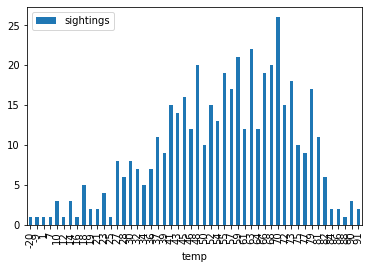

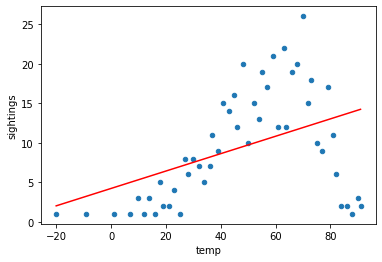

In [23]:
# Plot comparisons for sightings vs. temperature
ufo_temp = ufo_sample.groupby("temp").count()
ufo_temp = ufo_temp.reset_index()
ufo_temp.plot(kind="bar", y="sightings", x="temp")
ufo_temp.plot(kind="scatter", y="sightings", x="temp")
(slope, intercept, rvalue, pvalue, sterr) = linregress(ufo_temp["temp"], ufo_temp["sightings"])
regressValues = (slope*ufo_temp["temp"]) + intercept
plt.plot(ufo_temp["temp"], regressValues,"red")

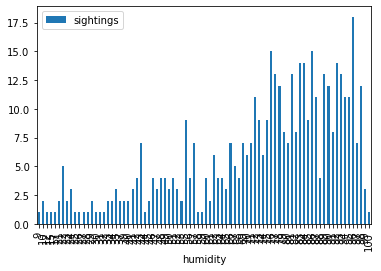

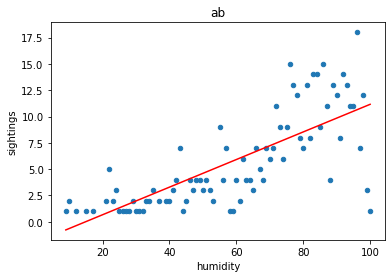

In [27]:
# Plot comparisons for sightings vs. humidity
ufo_temp = ufo_sample.groupby("humidity").count()
ufo_temp = ufo_temp.reset_index()
ufo_temp.plot(kind="bar", y="sightings", x="humidity")
ufo_temp.plot(kind="scatter", y="sightings", x="humidity",title="ab")
(slope, intercept, rvalue, pvalue, sterr) = linregress(ufo_temp["humidity"], ufo_temp["sightings"])
regressValues = (slope*ufo_temp["humidity"]) + intercept
plt.plot(ufo_temp["humidity"], regressValues,"red")

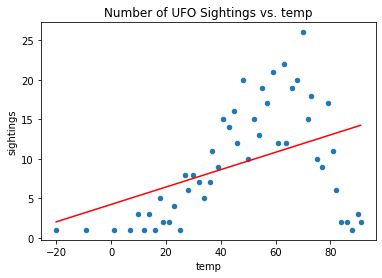

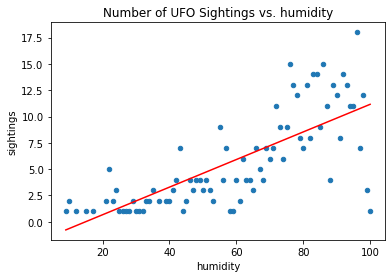

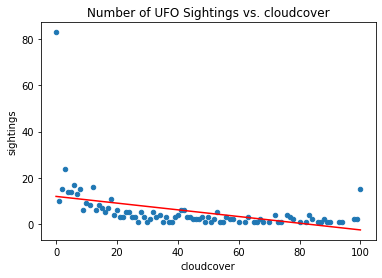

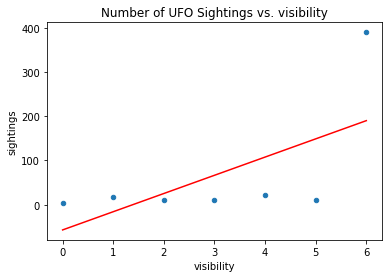

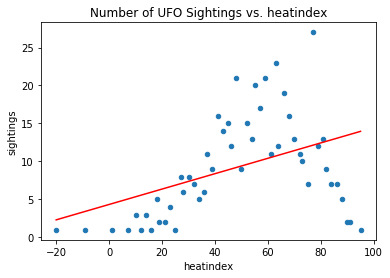

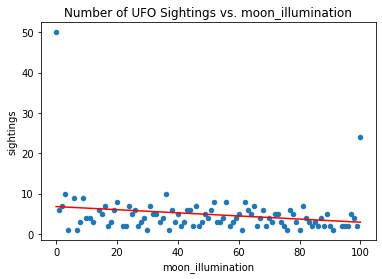

In [31]:
# Plot comparisons for sightings vs. weather varaibles
variables = ["temp", "humidity", "cloudcover", "visibility", "heatindex", "moon_illumination"]

for x in variables:
    ufo_temp = ufo_sample.groupby(x).count()
    ufo_temp = ufo_temp.reset_index()
#     ufo_temp.plot(kind="bar", y="sightings", x=x, 
#                   title=f"Number of UFO Sightings vs. {x}")
    ufo_temp.plot(kind="scatter", y="sightings", x=x, 
                  title=f"Number of UFO Sightings vs. {x}")
    (slope, intercept, rvalue, pvalue, sterr) = linregress(ufo_temp[x], ufo_temp["sightings"])
    regressValues = (slope*ufo_temp[x]) + intercept
    plt.plot(ufo_temp[x], regressValues,"red")
    
    plt.savefig(f"Weather_Graphs/{x}_ufo.png")